# Recommending attractive locations for restaurants using data analysis methods.

## **Introduction**

Establishing a restaurant involves setting many criteria and having a       vision of what you want to deliver to your potential customers. I mean here such aspects as the type of cuisine served, the definition of the type of customers for which it should be a place, decor, location, etc.


## **Business Problem**

This analysis is for those who know what kind of cuisine they want to serve in their restaurant. I will focus on identifying good/not good locations for this restaurant. The choice must be based on an analysis of many factors such as: the population of the district, the popularity of the area among people, the proximity of popular public transport, the proximity of other urban infrastructure and the most important is the number of units in the area offering the same type of cuisine.

# Data acquisition

I will use data sources such as:

• List of Toronto postal codes from [WIKIPEDIA.](https://https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)

• Geospatial Coordinates CSV file for Toronto postal codes from http://cocl.us/Geospatial_data.

• Foursquare API - to explore venues in Toronto neighbourhoods

I'll use the Toronto postal code list from Wikipedia. In this list every neighborhood of Toronto is assigned a corresponding postcode. Then I will join a csv file with geolocation data to this list. After connecting, each neighborhood will be assigned the appropriate latitude and longitude value. Finally I will use Foursquare API to explore these districts. The collected data will allow me to solve the task.

## Below I present the process of obtaining raw data and processing it into data to be used for analysis.

#### Importing libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
from bs4 import BeautifulSoup

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
sns.set()

##### Setting pandas options

In [0]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

----------------------

# 1. Downloading the Toronto postcode table from Wikipedia and converting it to Pandas Data Frame

In [4]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
page = requests.get(url)
print(page.status_code)

200


#### Creating BeautifulSoup instance

In [0]:
soup = BeautifulSoup(page.content, 'html.parser')

#### Searching for table in wikipedia site

In [0]:
tb = soup.find('table', class_='wikitable')

#### Creating list with all table rows

In [0]:
t_row=tb.findAll('tr')

In [8]:
t_row[5].findAll('td')  # view of single row

[<td>M5A
 </td>, <td>Downtown Toronto
 </td>, <td>Regent Park, Harbourfront
 </td>]

#### Creating a list with clean data in rows

In [0]:
final=[]
for k in t_row[1:]:
    temp=[]
    for i in range(0,3):
        item=k.findAll('td')[i].get_text().replace('\n','')
        temp.append(item)
    final.append(temp)

#### Checking the preview of the list items

In [10]:
final[0:3] 

[['M1A', 'Not assigned', ''],
 ['M2A', 'Not assigned', ''],
 ['M3A', 'North York', 'Parkwoods']]

#### Extracting columns names

In [0]:
columns_df=str(t_row[0]).replace('<tr>\n<th>','').replace('\n</th>','').replace('</tr>','').split('\n<th>')

#### Creating raw data frame

In [12]:
table=pd.DataFrame(final, columns=columns_df)
table.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,
1,M2A,Not assigned,
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [13]:
table.shape

(180, 3)

#### Delete rows with blank entries in column "Borough"

In [14]:
table=table[table.Borough != 'Not assigned']
table.reset_index(inplace=True, drop=True)
table.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


#### Loop for replaceing "/" to ","

In [15]:
table['Postal Code'].value_counts().shape

(103,)

In [16]:
table[table['Neighborhood']==''].count()

Postal Code     0
Borough         0
Neighborhood    0
dtype: int64

In [17]:
print('My table has {} rows.'.format(table.shape[0]))

My table has 103 rows.


--------------------------------------------------------------------------------------------

# 2. Merging Toronto postal codes DataFrame and CSV file with geolocalisation data

In [0]:
cords=pd.read_csv('http://cocl.us/Geospatial_data')

In [19]:
cords.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


#### Creating final data frame

In [0]:
table_cords=pd.merge(table, cords, how='left', left_on='Postal Code', right_on='Postal Code')
#del table_cords['Postal code']

In [21]:
table_cords.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


#### Creating map of Toronto

In [22]:
address = 'Toronto, ONT'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.678523999999996, -79.62912913064454.


In [23]:
# creating map of Toronto using latitude and longitude values
map_toronto=folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(table_cords['Latitude'], table_cords['Longitude'], table_cords['Borough'], table_cords['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

-----------------------------------------------------

# 3. Using the Foursquare API to explore neighborhoods

In [24]:
#path to file with Foursquare API credentials
cd '/content/drive/My Drive/Colab Notebooks/Coursera_Capstone'

/content/drive/My Drive/Colab Notebooks/Coursera_Capstone


In [0]:
credentials=list(pd.read_csv('credentials.csv'))

In [26]:
# Cell with hidden Foursquare API credentials

CLIENT_ID = credentials[0] # your Foursquare ID
CLIENT_SECRET = credentials[1] # your Foursquare Secret
VERSION = '20200430' # Foursquare API version
print('Credentials OK')

Credentials OK


-----------------------------------------------------------------------

# 4. Exploring neighborhoods

In [0]:
LIMIT = 100
radius = 500

#### Function which getting top 100 venues that are in Toronto's neighborhoods within a radius of 500 meters from their centers.

In [0]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue Id',
                  'Venue Name', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [29]:
toronto_venues = getNearbyVenues(names=table_cords['Neighborhood'],
                                   latitudes=table_cords['Latitude'],
                                   longitudes=table_cords['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview
The Danforth West, Ri

In [30]:
print('toronto_venues DataFrame size: ',toronto_venues.shape)

toronto_venues DataFrame size:  (2115, 8)


In [31]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Id,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,4e8d9dcdd5fbbbb6b3003c7b,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,4e6696b6d16433b9ffff47c3,KFC,43.754387,-79.333021,Fast Food Restaurant
2,Parkwoods,43.753259,-79.329656,4cb11e2075ebb60cd1c4caad,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,4c633acb86b6be9a61268e34,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,4bbe904a85fbb713420d7167,Tim Hortons,43.725517,-79.313103,Coffee Shop


#### Number of venues in each neighborhood

In [32]:
toronto_venues['Neighborhood'].value_counts().head(10)

Toronto Dominion Centre, Design Exchange             100
Garden District, Ryerson                             100
Harbourfront East, Union Station, Toronto Islands    100
First Canadian Place, Underground city               100
Commerce Court, Victoria Hotel                       100
Stn A PO Boxes                                        94
Richmond, Adelaide, King                              93
St. James Town                                        76
Church and Wellesley                                  73
Fairview, Henry Farm, Oriole                          64
Name: Neighborhood, dtype: int64

#### Number of unique categories in all venues

In [33]:
toronto_venues['Venue Category'].nunique()

266

#### Extraction of all categories with the word "restaurant" in the name, from all possible categories.

In [0]:
toronto_venues = toronto_venues[toronto_venues['Venue Category'].str.contains("(?i)restaurant")].reset_index().drop("index", axis=1)

In [35]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Id,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,4e6696b6d16433b9ffff47c3,KFC,43.754387,-79.333021,Fast Food Restaurant
1,Victoria Village,43.725882,-79.315572,4f3ecce6e4b0587016b6f30d,Portugril,43.725819,-79.312785,Portuguese Restaurant
2,Victoria Village,43.725882,-79.315572,4d689350b6f46dcb77ee15b2,The Frig,43.727051,-79.317418,French Restaurant
3,"Regent Park, Harbourfront",43.654260,-79.360636,5612b1cc498e3dd742af0dc8,Impact Kitchen,43.656369,-79.356980,Restaurant
4,"Regent Park, Harbourfront",43.654260,-79.360636,53a22c92498ec91fda7ce133,Cluny Bistro & Boulangerie,43.650565,-79.357843,French Restaurant


In [36]:
print('There are {} venues with the word "restaurant"'.format(toronto_venues.shape[0]))

There are 494 venues with the word "restaurant"


#### Creating map with all "restaurant" venues 

In [37]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, name in zip(toronto_venues['Venue Latitude'], toronto_venues['Venue Longitude'] , toronto_venues['Venue Name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186c0',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [38]:
toronto_venues.groupby('Venue Category').count().sort_values('Neighborhood', ascending=False).iloc[:,0:1].head()

,Neighborhood
Venue Category,
Restaurant,71
Italian Restaurant,46
Japanese Restaurant,43
Fast Food Restaurant,29
Sushi Restaurant,29


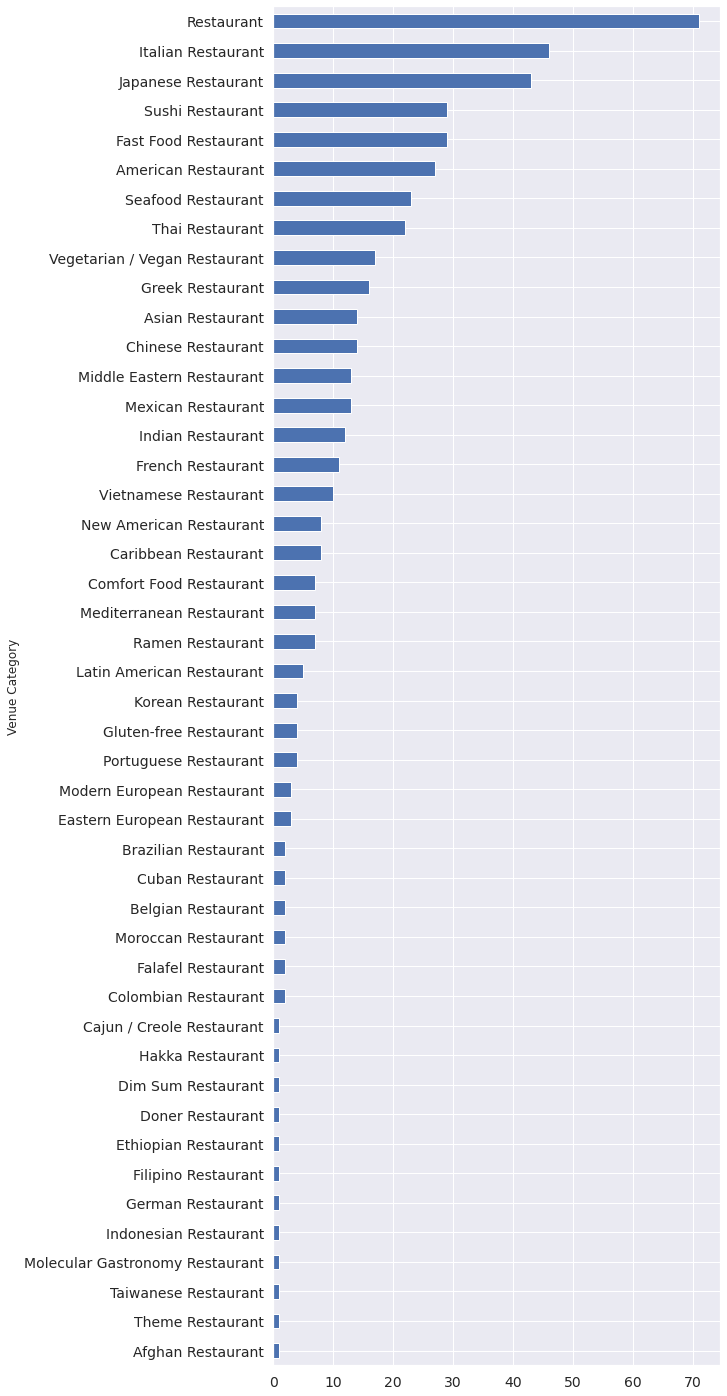

In [39]:
toronto_venues.groupby('Venue Category').size().sort_values(ascending=True).plot.barh(figsize=(8,25), fontsize = 14)

#### Analyzing each neighborhood

In [40]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']])

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Venue Category_Afghan Restaurant,Venue Category_American Restaurant,Venue Category_Asian Restaurant,Venue Category_Belgian Restaurant,Venue Category_Brazilian Restaurant,Venue Category_Cajun / Creole Restaurant,Venue Category_Caribbean Restaurant,Venue Category_Chinese Restaurant,Venue Category_Colombian Restaurant,Venue Category_Comfort Food Restaurant,Venue Category_Cuban Restaurant,Venue Category_Dim Sum Restaurant,Venue Category_Doner Restaurant,Venue Category_Eastern European Restaurant,Venue Category_Ethiopian Restaurant,Venue Category_Falafel Restaurant,Venue Category_Fast Food Restaurant,Venue Category_Filipino Restaurant,Venue Category_French Restaurant,Venue Category_German Restaurant,Venue Category_Gluten-free Restaurant,Venue Category_Greek Restaurant,Venue Category_Hakka Restaurant,Venue Category_Indian Restaurant,Venue Category_Indonesian Restaurant,Venue Category_Italian Restaurant,Venue Category_Japanese Restaurant,Venue Category_Korean Restaurant,Venue Category_Latin American Restaurant,Venue Category_Mediterranean Restaurant,Venue Category_Mexican Restaurant,Venue Category_Middle Eastern Restaurant,Venue Category_Modern European Restaurant,Venue Category_Molecular Gastronomy Restaurant,Venue Category_Moroccan Restaurant,Venue Category_New American Restaurant,Venue Category_Portuguese Restaurant,Venue Category_Ramen Restaurant,Venue Category_Restaurant,Venue Category_Seafood Restaurant,Venue Category_Sushi Restaurant,Venue Category_Taiwanese Restaurant,Venue Category_Thai Restaurant,Venue Category_Theme Restaurant,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Vietnamese Restaurant
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Grouping rows in relation to 'Neighborhood' and calculating the frequency of occurrence of the site in a given neighbourhood

In [41]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Venue Category_Afghan Restaurant,Venue Category_American Restaurant,Venue Category_Asian Restaurant,Venue Category_Belgian Restaurant,Venue Category_Brazilian Restaurant,Venue Category_Cajun / Creole Restaurant,Venue Category_Caribbean Restaurant,Venue Category_Chinese Restaurant,Venue Category_Colombian Restaurant,Venue Category_Comfort Food Restaurant,Venue Category_Cuban Restaurant,Venue Category_Dim Sum Restaurant,Venue Category_Doner Restaurant,Venue Category_Eastern European Restaurant,Venue Category_Ethiopian Restaurant,Venue Category_Falafel Restaurant,Venue Category_Fast Food Restaurant,Venue Category_Filipino Restaurant,Venue Category_French Restaurant,Venue Category_German Restaurant,Venue Category_Gluten-free Restaurant,Venue Category_Greek Restaurant,Venue Category_Hakka Restaurant,Venue Category_Indian Restaurant,Venue Category_Indonesian Restaurant,Venue Category_Italian Restaurant,Venue Category_Japanese Restaurant,Venue Category_Korean Restaurant,Venue Category_Latin American Restaurant,Venue Category_Mediterranean Restaurant,Venue Category_Mexican Restaurant,Venue Category_Middle Eastern Restaurant,Venue Category_Modern European Restaurant,Venue Category_Molecular Gastronomy Restaurant,Venue Category_Moroccan Restaurant,Venue Category_New American Restaurant,Venue Category_Portuguese Restaurant,Venue Category_Ramen Restaurant,Venue Category_Restaurant,Venue Category_Seafood Restaurant,Venue Category_Sushi Restaurant,Venue Category_Taiwanese Restaurant,Venue Category_Thai Restaurant,Venue Category_Theme Restaurant,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Vietnamese Restaurant
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
1,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.000000,0.0,0.333333,0.000000,0.333333,0.0,0.000000,0.0,0.000000,0.0
2,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
3,"Bedford Park, Lawrence Manor East",0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.100000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.100000,0.0,0.1,0.0,0.2,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.200000,0.000000,0.100000,0.0,0.100000,0.0,0.000000,0.0
4,Berczy Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.083333,0.0,0.166667,0.166667,0.000000,0.0,0.083333,0.0,0.083333,0.0


In [42]:
toronto_grouped.shape

(66, 47)

#### Top 5 common cuisines in each neighborhood

In [43]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['cuisine','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                                    cuisine  freq
0  Venue Category_Latin American Restaurant   1.0
1          Venue Category_Afghan Restaurant   0.0
2        Venue Category_Moroccan Restaurant   0.0
3         Venue Category_Italian Restaurant   0.0
4        Venue Category_Japanese Restaurant   0.0


----Bathurst Manor, Wilson Heights, Downsview North----
                                          cuisine  freq
0                 Venue Category_Sushi Restaurant  0.33
1                       Venue Category_Restaurant  0.33
2        Venue Category_Middle Eastern Restaurant  0.33
3                Venue Category_Afghan Restaurant  0.00
4  Venue Category_Molecular Gastronomy Restaurant  0.00


----Bayview Village----
                                  cuisine  freq
0      Venue Category_Japanese Restaurant   0.5
1       Venue Category_Chinese Restaurant   0.5
2        Venue Category_Afghan Restaurant   0.0
3  Venue Category_New American Restaurant   0.0
4        Venue Categor

#### Inserting the above information into the DataFrame

In [0]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [45]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top cuisine
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common cuisine'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common cuisine'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common cuisine,2nd Most Common cuisine,3rd Most Common cuisine,4th Most Common cuisine,5th Most Common cuisine
0,Agincourt,Venue Category_Latin American Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Dim Sum Restaurant,Venue Category_German Restaurant,Venue Category_French Restaurant
1,"Bathurst Manor, Wilson Heights, Downsview North",Venue Category_Sushi Restaurant,Venue Category_Restaurant,Venue Category_Middle Eastern Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Cuban Restaurant
2,Bayview Village,Venue Category_Japanese Restaurant,Venue Category_Chinese Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Dim Sum Restaurant,Venue Category_German Restaurant
3,"Bedford Park, Lawrence Manor East",Venue Category_Restaurant,Venue Category_Italian Restaurant,Venue Category_Comfort Food Restaurant,Venue Category_American Restaurant,Venue Category_Thai Restaurant
4,Berczy Park,Venue Category_Seafood Restaurant,Venue Category_Restaurant,Venue Category_Greek Restaurant,Venue Category_Thai Restaurant,Venue Category_Vegetarian / Vegan Restaurant


----------------------------------------------------------------------------------------------------------------------------------------------------------------

# 5. Clustering

#### k-means method (10 clusters)

In [46]:
# set number of clusters
kclusters = 10

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 3, 2, 0, 0, 8, 2, 0, 0, 0], dtype=int32)

#### Labelling of clusters

In [0]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

#### Creating a new DataFrame

In [48]:
toronto_merged = neighborhoods_venues_sorted
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(table_cords.set_index('Neighborhood'), on='Neighborhood').reset_index()
toronto_merged.tail()

,index,Cluster Labels,Neighborhood,1st Most Common cuisine,2nd Most Common cuisine,3rd Most Common cuisine,4th Most Common cuisine,5th Most Common cuisine,Postal Code,Borough,Latitude,Longitude
66,62,5,Westmount,Venue Category_Chinese Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Dim Sum Restaurant,Venue Category_Gluten-free Restaurant,Venue Category_German Restaurant,M9P,Etobicoke,43.696319,-79.532242
67,63,9,"Wexford, Maryvale",Venue Category_Middle Eastern Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Dim Sum Restaurant,Venue Category_German Restaurant,Venue Category_French Restaurant,M1R,Scarborough,43.750072,-79.295849
68,64,0,Willowdale,Venue Category_Ramen Restaurant,Venue Category_Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Fast Food Restaurant,Venue Category_Sushi Restaurant,M2N,North York,43.770120,-79.408493
69,64,0,Willowdale,Venue Category_Ramen Restaurant,Venue Category_Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Fast Food Restaurant,Venue Category_Sushi Restaurant,M2R,North York,43.782736,-79.442259
70,65,1,Woburn,Venue Category_Korean Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Dim Sum Restaurant,Venue Category_German Restaurant,Venue Category_French Restaurant,M1G,Scarborough,43.770992,-79.216917


#### Clusters size

In [49]:
toronto_merged.groupby('Cluster Labels').size()

Cluster Labels
0    35
1     5
2    11
3     6
4     4
5     2
6     2
7     1
8     3
9     2
dtype: int64

#### Visualization of venues on the map with division into clusters

In [50]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Adding "cluster Labels" to "toronto_grouped" dataframe

In [0]:
toronto_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

In [0]:
toronto_clusters = toronto_grouped.groupby('Cluster Labels').mean()

In [53]:
toronto_clusters.head()

,Venue Category_Afghan Restaurant,Venue Category_American Restaurant,Venue Category_Asian Restaurant,Venue Category_Belgian Restaurant,Venue Category_Brazilian Restaurant,Venue Category_Cajun / Creole Restaurant,Venue Category_Caribbean Restaurant,Venue Category_Chinese Restaurant,Venue Category_Colombian Restaurant,Venue Category_Comfort Food Restaurant,Venue Category_Cuban Restaurant,Venue Category_Dim Sum Restaurant,Venue Category_Doner Restaurant,Venue Category_Eastern European Restaurant,Venue Category_Ethiopian Restaurant,Venue Category_Falafel Restaurant,Venue Category_Fast Food Restaurant,Venue Category_Filipino Restaurant,Venue Category_French Restaurant,Venue Category_German Restaurant,Venue Category_Gluten-free Restaurant,Venue Category_Greek Restaurant,Venue Category_Hakka Restaurant,Venue Category_Indian Restaurant,Venue Category_Indonesian Restaurant,Venue Category_Italian Restaurant,Venue Category_Japanese Restaurant,Venue Category_Korean Restaurant,Venue Category_Latin American Restaurant,Venue Category_Mediterranean Restaurant,Venue Category_Mexican Restaurant,Venue Category_Middle Eastern Restaurant,Venue Category_Modern European Restaurant,Venue Category_Molecular Gastronomy Restaurant,Venue Category_Moroccan Restaurant,Venue Category_New American Restaurant,Venue Category_Portuguese Restaurant,Venue Category_Ramen Restaurant,Venue Category_Restaurant,Venue Category_Seafood Restaurant,Venue Category_Sushi Restaurant,Venue Category_Taiwanese Restaurant,Venue Category_Thai Restaurant,Venue Category_Theme Restaurant,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Vietnamese Restaurant
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.001212,0.08777,0.018684,0.003608,0.002273,0.004329,0.021157,0.021030,0.002273,0.017424,0.00947,0.00303,0.002165,0.011544,0.001263,0.004962,0.016592,0.002165,0.032504,0.001443,0.004328,0.029917,0.010101,0.038911,0.002755,0.090160,0.073020,0.003489,0.039731,0.016393,0.017626,0.031045,0.00412,0.001443,0.002886,0.011258,0.01912,0.013597,0.108326,0.034735,0.064387,0.002755,0.050603,0.001212,0.033735,0.02945
1,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2,0.000000,0.02972,0.006993,0.000000,0.000000,0.000000,0.000000,0.136364,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.337063,0.000000,0.000000,0.000000,0.000000,0.006993,0.000000,0.045455,0.000000,0.040909,0.111888,0.000000,0.000000,0.045455,0.022727,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.152797,0.022727,0.018182,0.000000,0.022727,0.000000,0.000000,0.00000
3,0.000000,0.00000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023810,0.023810,0.000000,0.000000,0.000000,0.362698,0.055556,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.201587,0.000000,0.242063,0.000000,0.000000,0.000000,0.023810,0.00000
4,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


#### Creating heat map

In [0]:
toronto_clusters_transposed = toronto_clusters.transpose()

In [55]:
toronto_clusters_transposed.head()

Cluster Labels,0,1,2,3,4,5,6,7,8,9
Venue Category_Afghan Restaurant,0.001212,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Venue Category_American Restaurant,0.087770,0.0,0.029720,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Venue Category_Asian Restaurant,0.018684,0.0,0.006993,0.033333,0.0,0.0,0.0,0.0,0.0,0.0
Venue Category_Belgian Restaurant,0.003608,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Venue Category_Brazilian Restaurant,0.002273,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


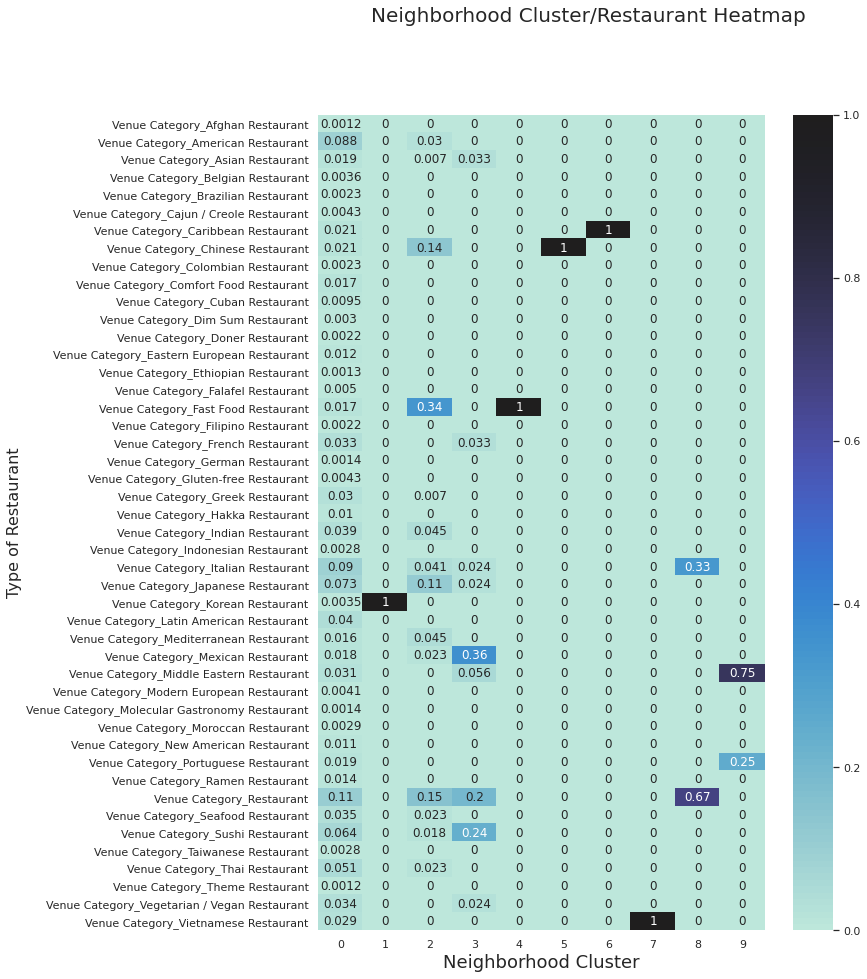

In [56]:

fig, ax = plt.subplots(figsize=(10,15))  
# plot heatmap

ax = sns.heatmap(toronto_clusters_transposed, center=1, annot=True, ax=ax)

fig.suptitle('Neighborhood Cluster/Restaurant Heatmap', fontsize=20)
plt.xlabel('Neighborhood Cluster', fontsize=18)
plt.ylabel('Type of Restaurant', fontsize=16)
# save figure
plt.show()

If the cell is darker on the Heat Map, the more often the restaurant type is present in the cluster. In this case, we may advise against opening a restaurant in a place that belongs to a given cluster.

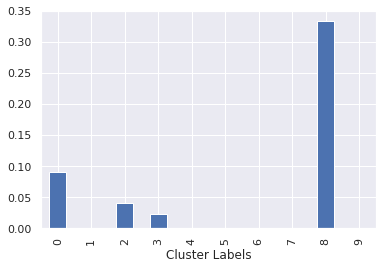

In [57]:
toronto_clusters_transposed.loc['Venue Category_Italian Restaurant'].plot(kind='bar')

#### The occurrence of restaurants serving italian cuisine is frequent in cluster no. 8. Therefore, it is unreasonable to open restaurants with such cuisine in a district qualified for this cluster.